## 라이브러리 로딩

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [ ]:

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

## 데이터 다운로드

In [ ]:
!wget 'https://bit.ly/3dD5MU9'

import zipfile
with zipfile.ZipFile('3dD5MU9', 'r') as existing_zip:
    existing_zip.extractall('data')

--2021-05-31 14:07:52--  https://bit.ly/3dD5MU9
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z [following]
--2021-05-31 14:07:52--  https://drive.google.com/uc?export=download&id=1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z
Resolving drive.google.com (drive.google.com)... 64.233.189.138, 64.233.189.100, 64.233.189.113, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a9rht5l39julpra3im9h687spt6gac6i/1622470050000/00192245294648390361/*/1kkF00wW8v0npJ8S2nA7--eMTH3gOL03z?e=download [following]
--2021-05-31 14:07:58--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/

In [ ]:
energy = pd.read_csv('data/energy.csv')
dangjin_fcst = pd.read_csv('./data/dangjin_fcst_data.csv')
ulsan_fcst = pd.read_csv('./data/ulsan_fcst_data.csv')

## 데이터 병합

In [ ]:
def to_date(x):
    return timedelta(hours=x)

In [49]:
def generate_df(df_):
    df = df_.copy()

    df['Forecast_time'] = pd.to_datetime(df['Forecast time'])

    # 20 시
    a = df[df["forecast"] == 4.0]
    a = a[a["Forecast time"].apply(lambda x: "20:00:00" in x)]
    a.loc[:, 'Forecast_time'] = a.loc[:, 'Forecast_time'] + a.loc[:, 'forecast'].map(to_date)

    # 23 시
    b = df[df["forecast"] <= 22]
    b = b[b["Forecast time"].apply(lambda x: "23:00:00" in x)]
    b.loc[:, 'Forecast_time'] = b.loc[:, 'Forecast_time'] + b.loc[:, 'forecast'].map(to_date)

    # 병합
    c = pd.concat([a, b])
    print(f"20시 사용 데이터 길이 : {len(a)}")
    print(f"23시 사용 데이터 길이 : {len(b)}")
    print(f"합친 데이터 길이 : {len(c)}")
    print()

    # 정렬
    c.sort_values(by=['Forecast_time'], inplace=True)
    c = c[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

    return c

In [50]:
dangjin_filled = generate_df(dangjin_fcst)
ulsan_filled = generate_df(ulsan_fcst)

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768

20시 사용 데이터 길이 : 1096
23시 사용 데이터 길이 : 7672
합친 데이터 길이 : 8768



## 보간

In [51]:
def interpolate_df(df, method='linear'):
    new_df = pd.DataFrame()
    new_df['Forecast_time'] = pd.date_range(start=df['Forecast_time'].iloc[0], end=df['Forecast_time'].iloc[-1], freq='H')
    new_df = pd.merge(new_df, df, on='Forecast_time', how='outer')
    return new_df.interpolate(method=method)

In [52]:
dangjin_interpolated = interpolate_df(dangjin_filled, method='linear')
ulsan_interpolated = interpolate_df(ulsan_filled, method='linear')

In [59]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    

    return     feature_df 


In [55]:
dangjin_interpolated['Forecast_time'] = dangjin_interpolated['Forecast_time'].astype('str')
ulsan_interpolated['Forecast_time'] = ulsan_interpolated['Forecast_time'].astype('str')

In [60]:
train = train_datast(energy, dangjin_interpolated, target='dangjin_floating')

In [61]:
train = train.set_index('Forecast_time')


In [36]:
len(train_set[0])

6

In [63]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [64]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [ ]:
reframed = series_to_supervised(train, 674, 674)

## 모델링


## 하이퍼 파라미터 설정

In [80]:
values = reframed.values
n_train_hours = 365 * 24 #1년치 데이터만 가져온다
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [73]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np


In [81]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [82]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
        validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 2s - loss: 129.7900
Epoch 2/50
122/122 - 0s - loss: 128.2335
Epoch 3/50
122/122 - 0s - loss: 127.0178
Epoch 4/50
122/122 - 0s - loss: 126.1044
Epoch 5/50
122/122 - 0s - loss: 125.1168
Epoch 6/50
122/122 - 0s - loss: 124.3215
Epoch 7/50
122/122 - 0s - loss: 123.6624
Epoch 8/50
122/122 - 0s - loss: 122.8710
Epoch 9/50
122/122 - 0s - loss: 121.8375
Epoch 10/50
122/122 - 0s - loss: 120.9438
Epoch 11/50
122/122 - 0s - loss: 120.3145
Epoch 12/50
122/122 - 0s - loss: 119.7341
Epoch 13/50
122/122 - 0s - loss: 118.7728
Epoch 14/50
122/122 - 0s - loss: 117.8995
Epoch 15/50
122/122 - 0s - loss: 117.2570
Epoch 16/50
122/122 - 0s - loss: 116.5838
Epoch 17/50
122/122 - 0s - loss: 115.7842
Epoch 18/50
122/122 - 0s - loss: 115.1697
Epoch 19/50
122/122 - 0s - loss: 114.6744
Epoch 20/50
122/122 - 0s - loss: 113.9721
Epoch 21/50
122/122 - 0s - loss: 113.3907
Epoch 22/50
122/122 - 0s - loss: 112.6996
Epoch 23/50
122/122 - 0s - loss: 111.6174
Epoch 24/50
122/122 - 0s - loss: 111.1364
E

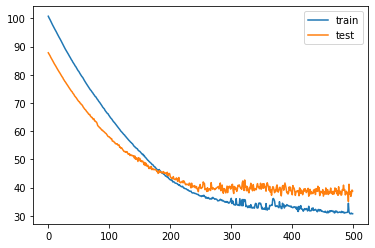

In [78]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()